<a href="https://colab.research.google.com/github/rohit-1026/House-Price-Prediction/blob/main/House_Price_Pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Dataset and Libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams["figure.figsize"] = (20,10)
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
dir_path = ('/content/drive/MyDrive/Colab Notebooks/Code Basics/House_Price_Pred/')
df = pd.read_csv(dir_path + ('/Bengaluru_House_Data.csv'))

# Dataset Overview

In [4]:
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [5]:
print(df.shape)

(13320, 9)


In [6]:
df.columns

Index(['area_type', 'availability', 'location', 'size', 'society',
       'total_sqft', 'bath', 'balcony', 'price'],
      dtype='object')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   availability  13320 non-null  object 
 2   location      13319 non-null  object 
 3   size          13304 non-null  object 
 4   society       7818 non-null   object 
 5   total_sqft    13320 non-null  object 
 6   bath          13247 non-null  float64
 7   balcony       12711 non-null  float64
 8   price         13320 non-null  float64
dtypes: float64(3), object(6)
memory usage: 936.7+ KB


# Data Cleaning

## Decreasing Columns

In [8]:
df['area_type'].value_counts()

Super built-up  Area    8790
Built-up  Area          2418
Plot  Area              2025
Carpet  Area              87
Name: area_type, dtype: int64

Dropping some columns assuming they are not imp in price prediction

* area type
* society
* balcony
* availability

In [9]:
df1 = df.drop(['area_type','society','balcony','availability'], axis = 1)

In [10]:
df1.head()

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00


## Null values

In [11]:
# Finding the null values in out dataset

df1.isnull().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

Number of null values are extremly low when compared to 13000+ rows. So we can simply drop them


In [12]:
# Dropping null rows

df2 = df1.dropna()
df2.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

## Column: Size


In [13]:
# Exploring Size column

df2['size'].unique()

array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '6 Bedroom', '3 Bedroom',
       '1 BHK', '1 RK', '1 Bedroom', '8 Bedroom', '2 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', '9 Bedroom', '27 BHK', '10 Bedroom', '11 Bedroom',
       '10 BHK', '19 BHK', '16 BHK', '43 Bedroom', '14 BHK', '8 BHK',
       '12 Bedroom', '13 BHK', '18 Bedroom'], dtype=object)

* There are seperate words for same aspect. Therefore we need to combine them properly
* For that we'll create a new column 'bhk' and distribute our data

In [14]:
df2['bhk'] = df2['size'].apply(lambda x: int(x.split(' ')[0]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [15]:
df2.head()

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00,4
2,Uttarahalli,3 BHK,1440,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00,3
4,Kothanur,2 BHK,1200,2.0,51.00,2


In [16]:
df2['bhk'].unique()

array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18])

## Column: Total square feet

In [17]:
df2['total_sqft'].unique()

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      dtype=object)

* There are some ranges mentioned in the above result
* We will check which rows have ranges given and can use mean of that range

In [18]:
def is_float(x):
  try:
    float(x)
  except:
    return False
  return True

In [19]:
# df2[df2['total_sqft'].apply(is_float)]  This will return all the data which has a float value and not ranges
# Since we need rows with range we can simply use ~ to get the opposide of float values

df2[~df['total_sqft'].apply(is_float)].head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


,location,size,total_sqft,bath,price,bhk
30,Yelahanka,4 BHK,2100 - 2850,4.0,186.000,4
122,Hebbal,4 BHK,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2
165,Sarjapur,2 BHK,1145 - 1340,2.0,43.490,2
188,KR Puram,2 BHK,1015 - 1540,2.0,56.800,2
410,Kengeri,1 BHK,34.46Sq. Meter,1.0,18.500,1
549,Hennur Road,2 BHK,1195 - 1440,2.0,63.770,2
648,Arekere,9 Bedroom,4125Perch,9.0,265.000,9
661,Yelahanka,2 BHK,1120 - 1145,2.0,48.130,2
672,Bettahalsoor,4 Bedroom,3090 - 5002,4.0,445.000,4


* Now we have all the rows where a range is mentioned instead of a specific value
* Next step will be creating a function which will take mean of the range

In [20]:
def mean_value(x):
  sep = x.split('-')
  if len(sep) == 2:
    first = float(sep[0])
    second = float(sep[-1])
    mean_val = (first+second)/2
    return mean_val
  try:
    return float(x)
  except:
    return None

 Our funtion should solve 3 problems
1. It should give a mean value if range is encountered
2. It should return the same value if only 1 value is encountered
3. Should not return any value if its something with letters in it

In [21]:
mean_value('1200sq')

In [22]:
mean_value('1200')

1200.0

In [23]:
mean_value('1200 - 1500')

1350.0

Creating a copy of df2 for transforming ranges into single numbers

In [24]:
df3 = df2.copy()
df3['total_sqft'] = df3['total_sqft'].apply(mean_value)

df3.head()

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3
4,Kothanur,2 BHK,1200.0,2.0,51.00,2


In [25]:
df3.iloc[30,:]

location      Yelahanka
size              4 BHK
total_sqft       2475.0
bath                4.0
price             186.0
bhk                   4
Name: 30, dtype: object

## Column: Sq ft area

In [26]:
df3.head()

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3
4,Kothanur,2 BHK,1200.0,2.0,51.00,2


In [27]:
# Creating a new column 'Price per sqft

df4 = df3.copy()

df4['price_per_sqft'] = df4['price']*100000 / df4['total_sqft']
df4.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


## Column: Location

In [28]:
len(df4['location'].unique())

1304

In [29]:
df4['location'] = df4['location'].apply(lambda x: x.strip()) # For removing any extra spaces in the words

location_stats = df4.groupby('location')['location'].agg('count').sort_values(ascending = False)
location_stats

location
Whitefield               535
Sarjapur  Road           392
Electronic City          304
Kanakpura Road           266
Thanisandra              236
                        ... 
1 Giri Nagar               1
Kanakapura Road,           1
Kanakapura main  Road      1
Karnataka Shabarimala      1
whitefiled                 1
Name: location, Length: 1293, dtype: int64

In [30]:
# Check how many locations have less than 10 entries

len(location_stats[location_stats<=10])

1052

* 1052 out of 1293 locations have mentions less than 10 which is good
* We can categorize all of them as 'Other' location

To catergorize these in other
1. Create a variable containing all the locations with less than 10 mentions
2. Create a function which will mention 'other' in location column IF that name is present in our newly created variable
3. Apply the funtion on the column location

In [31]:
location_stat_less_than_10 = location_stats[location_stats<=10]
location_stat_less_than_10

location
Basapura                 10
1st Block Koramangala    10
Gunjur Palya             10
Kalkere                  10
Sector 1 HSR Layout      10
                         ..
1 Giri Nagar              1
Kanakapura Road,          1
Kanakapura main  Road     1
Karnataka Shabarimala     1
whitefiled                1
Name: location, Length: 1052, dtype: int64

In [32]:
# Total count of locations
len(df['location'].unique())

1306

In [33]:
# Total count of locations less than 10 mentions

len(location_stat_less_than_10)

1052

In [34]:
1306 - 1052 

254

In [35]:
df4['location'] = df4['location'].apply(lambda x: 'other' if x in location_stat_less_than_10 else x)

In [36]:
len(df4['location'].unique())

242

In [37]:
df4.head(10)

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000
5,Whitefield,2 BHK,1170.0,2.0,38.00,2,3247.863248
6,Old Airport Road,4 BHK,2732.0,4.0,204.00,4,7467.057101
7,Rajaji Nagar,4 BHK,3300.0,4.0,600.00,4,18181.818182
8,Marathahalli,3 BHK,1310.0,3.0,63.25,3,4828.244275
9,other,6 Bedroom,1020.0,6.0,370.00,6,36274.509804


In [38]:
df4[df4['location'] == 'other']

,location,size,total_sqft,bath,price,bhk,price_per_sqft
9,other,6 Bedroom,1020.0,6.0,370.00,6,36274.509804
18,other,3 BHK,2770.0,4.0,290.00,3,10469.314079
19,other,2 BHK,1100.0,2.0,48.00,2,4363.636364
25,other,3 BHK,1250.0,3.0,56.00,3,4480.000000
42,other,1 BHK,600.0,1.0,38.00,1,6333.333333
...,...,...,...,...,...,...,...
13291,other,1 Bedroom,812.0,1.0,26.00,1,3201.970443
13292,other,3 BHK,1440.0,2.0,63.93,3,4439.583333
13302,other,2 BHK,1075.0,2.0,48.00,2,4465.116279
13306,other,4 Bedroom,1200.0,5.0,325.00,4,27083.333333


## Outlier Detection

### Cross checking how many bhk flat is there and how much sqft area

In [39]:
df4[(df4['total_sqft']/df4['bhk']) <300]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
9,other,6 Bedroom,1020.0,6.0,370.0,6,36274.509804
45,HSR Layout,8 Bedroom,600.0,9.0,200.0,8,33333.333333
58,Murugeshpalya,6 Bedroom,1407.0,4.0,150.0,6,10660.980810
68,Devarachikkanahalli,8 Bedroom,1350.0,7.0,85.0,8,6296.296296
70,other,3 Bedroom,500.0,3.0,100.0,3,20000.000000
...,...,...,...,...,...,...,...
13277,other,7 Bedroom,1400.0,7.0,218.0,7,15571.428571
13279,other,6 Bedroom,1200.0,5.0,130.0,6,10833.333333
13281,Margondanahalli,5 Bedroom,1375.0,5.0,125.0,5,9090.909091
13303,Vidyaranyapura,5 Bedroom,774.0,5.0,70.0,5,9043.927649


We remove this from our main dataset

In [40]:
df4.shape

(13246, 7)

In [41]:
df5 = df4[~((df4['total_sqft']/df4['bhk']) <300)]
df5.shape

(12502, 7)

In [42]:
13246 - 744

12502

### Checking price per sqft

In [43]:
df5['price_per_sqft'].describe()

count     12456.000000
mean       6308.502826
std        4168.127339
min         267.829813
25%        4210.526316
50%        5294.117647
75%        6916.666667
max      176470.588235
Name: price_per_sqft, dtype: float64

In [44]:
def remove_pps_outlier(df):
  df_out = pd.DataFrame()
  for key, subdf in df.groupby('location'):
    m = np.mean(subdf['price_per_sqft'])
    st = np.std(subdf['price_per_sqft'])
    reduced_df = subdf[(subdf['price_per_sqft']>(m - st)) & (subdf['price_per_sqft']<= (m+st))]
    df_out = pd.concat([df_out, reduced_df], ignore_index = True)
  return df_out

In [45]:
df6 = remove_pps_outlier(df5)

In [46]:
df6.shape

(10241, 7)

# Vizualisation

## Bedrooms per flat

Create a funtion which will take a location as input and return the scatter plot of 2bhk and 3 bhk flats on prices vs sqft chart 

In [47]:
def plot_scatter_chart(df,location):
  bhk2 = df[(df['location'] == location) & (df['bhk'] == 2)]
  bhk3 =df[(df['location'] == location) & (df['bhk'] == 3)]
  matplotlib.rcParams['figure.figsize'] = (15,10)

  plt.scatter(bhk2['total_sqft'], bhk2['price'], color = 'blue', label = '2bhk', s=50)
  plt.scatter(bhk3['total_sqft'], bhk3['price'], color = 'green', marker = '+', label = '3bhk', s=50)
  plt.xlabel('Total Square-Feet')
  plt.ylabel('Total Price')
  plt.title('Location')
  plt.legend()

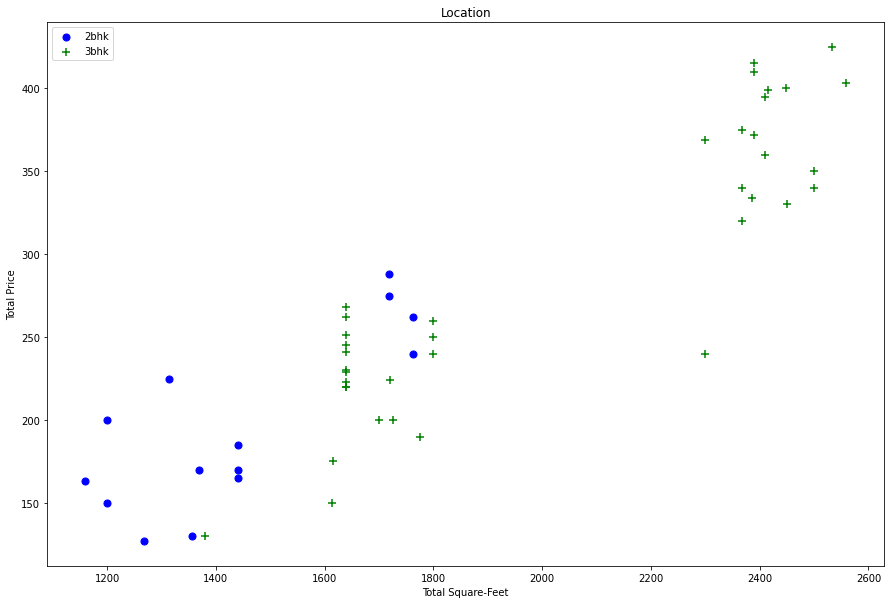

In [48]:
plot_scatter_chart(df6, 'Rajaji Nagar')

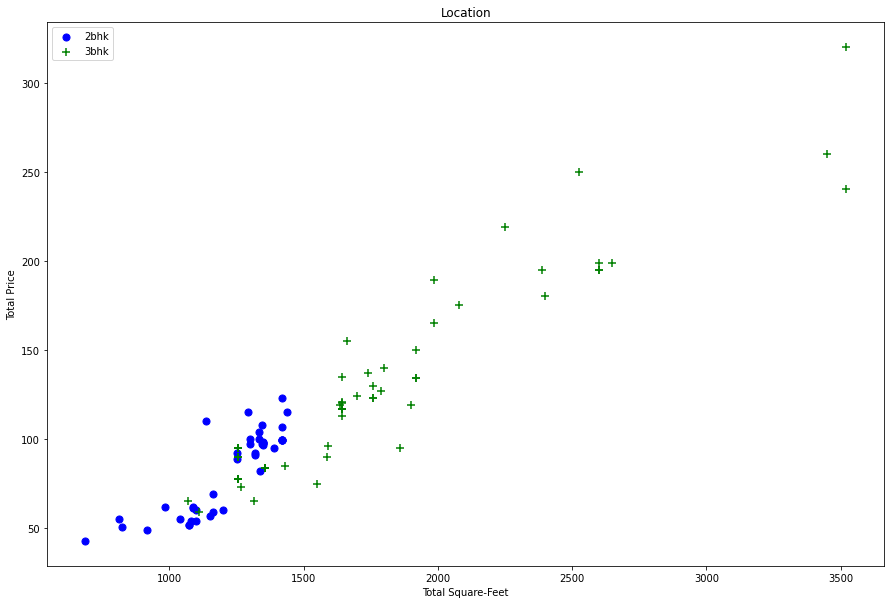

In [49]:
plot_scatter_chart(df6, 'Hebbal')

* We can see there are some instances where the price of 2bhk are less than 3 bhk for same area
* What we can do in this case is that we can calculate mean for 1 bhk house of that area and all those 2 bhk houses which have prices less than the mean can be eliminated

In [51]:
def remove_bhk_outliers(df):
  exclude_indices = np.array([])
  for location, location_df in df.groupby('location'):
    bhk_stats = {}
    for bhk, bhk_df in location_df.groupby('bhk'):
      bhk_stats[bhk] = {
          'mean' : np.mean(bhk_df['price_per_sqft']),
          'std' : np.std(bhk_df['price_per_sqft']),
          'count' : bhk_df.shape[0]
      }

    for bhk, bhk_df in location_df.groupby('bhk'):
      stats = bhk_stats.get(bhk-1)
      if stats and stats['count'] > 5:
        exclude_indices = np.append(exclude_indices, bhk_df[bhk_df['price_per_sqft']<(stats['mean'])].index.values)
  return df.drop(exclude_indices, axis = 'index')

In [52]:
df7 = remove_bhk_outliers(df6)
df7.shape

(7329, 7)

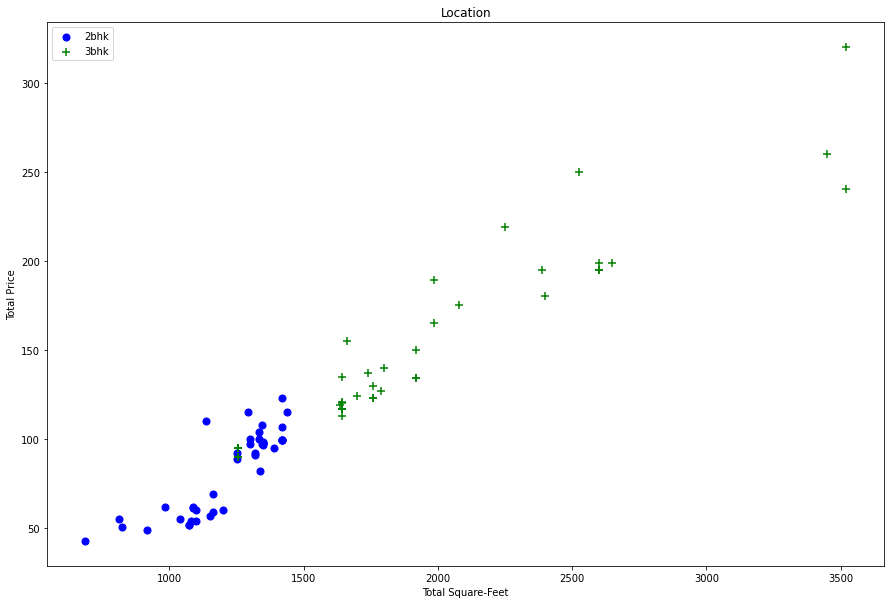

In [54]:
plot_scatter_chart(df7, 'Hebbal')

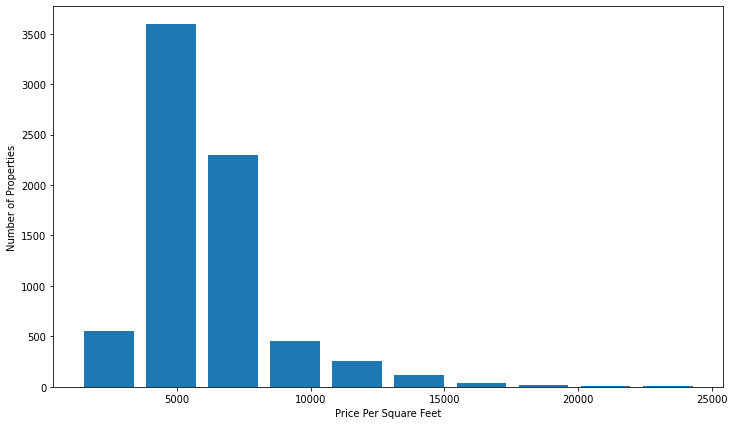

In [57]:
# Checking how many properties do we have in per sqft area

matplotlib.rcParams['figure.figsize'] = (12,7)
plt.hist(df7['price_per_sqft'], rwidth = 0.8)
plt.xlabel('Price Per Square Feet')
plt.ylabel('Number of Properties')
plt.show()

## Bathrooms per flat

In [59]:
df7['bath'].unique()

array([ 4.,  3.,  2.,  5.,  8.,  1.,  6.,  7.,  9., 12., 16., 13.])

In [60]:
# Checking properties with more than 10 bathrooms

df7[df7['bath'] > 10]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
5277,Neeladri Nagar,10 BHK,4000.0,12.0,160.0,10,4000.000000
8486,other,10 BHK,12000.0,12.0,525.0,10,4375.000000
8575,other,16 BHK,10000.0,16.0,550.0,16,5500.000000
9308,other,11 BHK,6000.0,12.0,150.0,11,2500.000000
9639,other,13 BHK,5425.0,13.0,275.0,13,5069.124424


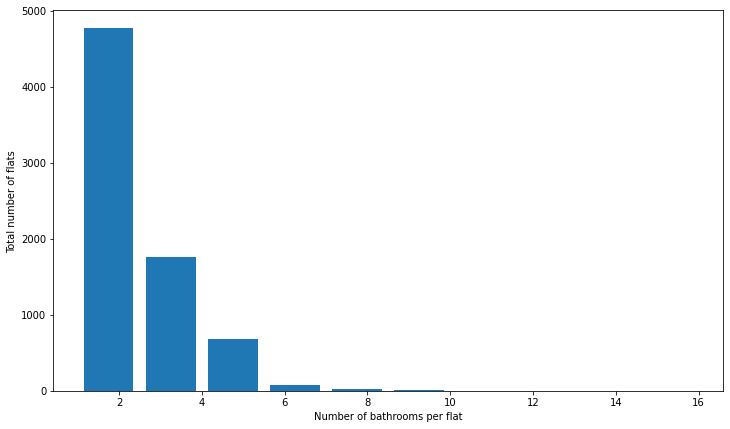

In [62]:
# Checking histogram of number of properties for various number of bathrooms

plt.hist(df7['bath'], rwidth = 0.8)
plt.xlabel('Number of bathrooms per flat')
plt.ylabel('Total number of flats')
plt.show()

* Now we can consider than the flat should not have more number of bathrooms than number of rooms
* We can consider no of bathrooms should not be greater than number of rooms + 2

In [63]:
df7[(df7['bath'] > df7['bhk'] + 2)]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
1626,Chikkabanavar,4 Bedroom,2460.0,7.0,80.0,4,3252.032520
5238,Nagasandra,4 Bedroom,7000.0,8.0,450.0,4,6428.571429
6711,Thanisandra,3 BHK,1806.0,6.0,116.0,3,6423.034330
8411,other,6 BHK,11338.0,9.0,1000.0,6,8819.897689


We can clearly see that these properties are not appropriate and we'll remove them

In [65]:
df8 = df7[(df7['bath'] < df7['bhk'] + 2)]
df8.shape

(7251, 7)

# Machine Learning algorithms

Firstly we can remove some columns that we do not need
* size | We have bhk as a column
* price_per_sqft | We have price and area

In [69]:
df8.columns

Index(['location', 'size', 'total_sqft', 'bath', 'price', 'bhk',
       'price_per_sqft'],
      dtype='object')

In [71]:
df9 = df8.drop(['price_per_sqft','size'], axis =1)
df9.head()

,location,total_sqft,bath,price,bhk
0,1st Block Jayanagar,2850.0,4.0,428.0,4
1,1st Block Jayanagar,1630.0,3.0,194.0,3
2,1st Block Jayanagar,1875.0,2.0,235.0,3
3,1st Block Jayanagar,1200.0,2.0,130.0,3
4,1st Block Jayanagar,1235.0,2.0,148.0,2
